In [1]:
import xgcm
import xarray as xr
import numpy as np
from xbasin import remap_vertical, compute_moc
from matplotlib import pyplot as plt
import cmocean as cm

In [2]:
#ds = xr.open_dataset('data/nemo_output_ex.nc')

In [3]:
from xnemogcm import open_nemo_and_domain_cfg

ds = open_nemo_and_domain_cfg(datadir='/home/romain/Documents/Education/PhD/Courses/2019-OC6310/Project/Experiments/EXP_eos00/Rawdata')

In [4]:

metrics_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w']
}
metrics_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_1d', 'e3w_1d']
}
grid = xgcm.Grid(ds, periodic=False, metrics=metrics_fr)


print(ds)

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 5, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t         

In [5]:
a0 = 1.655e-1
b0 = 7.6554e-1
l1 = 5.9520e-2
l2 = 0#5.4914e-4
nu = 0 #2.4341e-3
mu1 = 1.4970e-4
mu2 = 0 #1.1090e-5
T0 = 10
S0 = 35
rho0 = 1026
g = 9.81

def compute_rho(T, S, z, lambda1=5.9520e-2):
    if lambda1 is not None:
        l1 = lambda1
    Ta = T - T0
    Sa = S - S0
    rho = rho0 \
         - a0 * (1 + 0.5 * l1 * Ta + mu1 * z) * Ta \
         + b0 * (1 - 0.5 * l2 * Sa - mu2 * z) * Sa \
         - nu * Ta * Sa
    return rho

def compute_b(T, S, z, lambda1=5.9520e-2):
    return g * (rho0 - compute_rho(T, S, z, lambda1=lambda1)) / rho0

def compute_alpha(T, S, z, lambda1=5.9520e-2):
    if lambda1 is not None:
        l1 = lambda1
        print(l1)
    Ta = T - T0
    Sa = S - S0
    alpha = 1/rho0 * (a0 * (1 + l1 * Ta + mu1 * z) - nu * Sa)
    return alpha

def compute_beta(T, S, z):
    Ta = T - T0
    Sa = S - S0
    beta = 1/rho0 * b0 * (1 - l2 * Sa - mu2 * z)
    return beta

In [6]:
#ds.gdept_0[:,0] = ds.gdept_0[:,1]

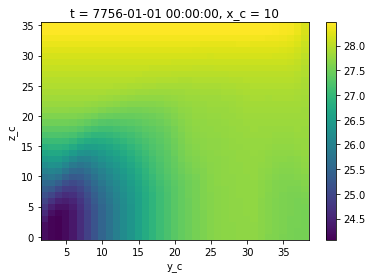

In [7]:
rho = compute_rho(ds.thetao, ds.so, ds.gdept_0, lambda1=4.9520e-2) - 1000


#crd_T[:,-1] = crd_T[:,-2]
# Try to stabilize the water column
for i in range(len(ds.z_c)-1):
    diff = (rho[:,i+1] - rho[:,i])
    mask = diff <= 0
    rho[:,i+1] -= mask * diff
    if mask.sum():
        #print(i)
        #print(np.min(diff).values)
        pass


ds['sigma'] = rho
rho[0,:,2:-1,10].plot()

We will use the following formula to compute the MOC streamfunction, using density as the tracer C.

$$\psi_{C y}=\iint_{C^{\prime} \leq C} v d x d z$$

### We create a new grid, based on constant levels of density

In [8]:
# Vertical (density)
s_min = np.int(ds['sigma'].values.flatten()[ds['sigma'].values.flatten() > 5].min())
s_max = np.int(ds['sigma'].values.flatten()[ds['sigma'].values.flatten() > 5].max()) + 1

print('(s_min, s_max)', (s_min, s_max))
dd = 0.05 #0.05
N = np.floor((s_max-s_min)/dd) + 1
#crd_T_new = np.arange(N) * dd + s_min
#crd_W_new = crd_T_new - dd/2

s_c = np.arange(N)
s_c = xr.DataArray(s_c, coords=[('s_c',s_c)])
s_c.attrs = ds.z_c.attrs
s_c.attrs['axis'] = 'S'
s_f = np.arange(N) - 0.5
s_f = xr.DataArray(s_f, coords=[('s_f',s_f)])
s_f.attrs = ds.z_f.attrs
s_f.attrs['axis'] = 'S'

grhot_0 = s_c * dd + s_min
grhow_0 = s_f * dd + s_min

e3t_1d = xr.DataArray(dd)
e3w_1d = xr.DataArray(dd)


ds['e3t_s_1d'] = e3t_1d
ds['e3w_s_1d'] = e3w_1d
ds['grhot_0'] = grhot_0
ds['grhow_0'] = grhow_0
ds['s_c'] = s_c
ds['s_f'] = s_f


(s_min, s_max) (23, 29)


In [9]:
rho_w = grid.interp(rho, axis='Z', boundary='extend')
ds['sigmaw'] = rho_w

### Scale factors

In [10]:
e3w = grid.diff(rho, axis='Z', boundary='extend')
e3t = grid.diff(rho_w, axis='Z', boundary='extend')
ds['e3t_sigma0'] = e3t
ds['e3w_sigma0'] = e3w

We actualize the grid with this new density coordinate

In [11]:
'''
metrics_sigma_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_sigma0', 'e3w_sigma0']
}
grid_sigma_fr = xgcm.Grid(ds, metrics=metrics_sigma_fr, periodic=False)

metrics_sigma_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('S',): ['e3t_s_1d', 'e3w_s_1d']
}
grid_sigma_to = xgcm.Grid(ds, metrics=metrics_sigma_to, periodic=False)
'''
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'],
    ('S',): ['e3t_s_1d', 'e3w_s_1d']
}
ds.e1v[{'x_c':[0,-2,-1]}] = 0
grid = xgcm.Grid(ds, periodic=False, metrics=metrics)

In [12]:
#ds.grhot_0

First integrate along z, for density values C' smaller than C.

$$\int_{C^{\prime} \leq C} v d z$$

Now we integrate along x.

$$\int \text{int_v_d} d x$$

In [13]:
int_v_dz = np.NaN * ds['s_f'] * ds.vo.isel({'z_c':0})

ds['sigma_V'] = grid.interp(ds['sigma'], axis='Y', boundary='extend')

In [14]:
%%time

for (i, sigma) in enumerate(ds.grhow_0):
    mask = (ds.sigma_V <= sigma)
    int_v_dz[{'s_f':i}] = (ds.vo * ds.e3v * mask).sum(dim='z_c')
    
psi = grid.integrate(int_v_dz, axis='X') * 1e-6

CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 582 ms


In [15]:
%%time
density_levels = ds.grhow_0

mask = (ds.sigma_V <= density_levels)
vertical_int = grid.integrate(ds.vo * mask, axis='Z')
psi = grid.integrate(vertical_int, axis='X') * 1e-6
# integrate from bottom
psi = psi - psi[{'s_f':-1}]

CPU times: user 104 ms, sys: 14.9 ms, total: 119 ms
Wall time: 118 ms


In [16]:
assert(((ds.vo * ds.e3v * mask).sum(dim='z_c') == grid.integrate(ds.vo * mask, axis='Z')).all())
print(np.abs(vertical_int - int_v_dz).max())

<xarray.DataArray ()>
array(0.)
Coordinates:
    z_c      int64 0


Using xgcm in one line, integration from the bottom

In [17]:
%%time
density_levels = ds.grhow_0
mask = (ds.sigma_V >= density_levels)
psi = -grid.integrate(grid.integrate(ds.vo * mask, axis='Z'), axis='X') * 1e-6

CPU times: user 90.8 ms, sys: 24 ms, total: 115 ms
Wall time: 112 ms


In [18]:
mask

<xarray.DataArray (t: 5, z_c: 36, y_f: 40, x_c: 21, s_f: 121)>
array([[[[[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         ...,

         [[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],


        [[[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         ...,

         [[False, False, False, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          ...,
          [ True,  True,  True, ..., False, False, False],
          [ True,  True,  True, ..., False, False, False],
          [False, False, False, ..., False, False, False]],

         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
   

We compute the density at the bottom of the MLD

In [19]:
%%time
index = (ds.gdepw_0 <= ds.mldr10_1).sum(dim='z_f')
sigma_mld = ds.mldr10_1.copy(deep=True)

for i in range(len(ds.x_c)):
    for j in range(len(ds.y_c)):
        for t in range(len(ds.t)):
            sigma_mld[{'x_c':i, 'y_c':j, 't':t}] = ds['sigma'].isel({'x_c':i, 'y_c':j, 't':t, 'z_c':index.isel({'x_c':i, 'y_c':j, 't':t})})

CPU times: user 4.49 s, sys: 959 µs, total: 4.49 s
Wall time: 4.49 s


Text(0.5, 0, 'latitude')

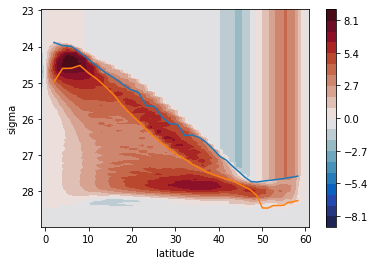

In [20]:
vmax = 10

plt.contourf(ds.gphif.isel({'x_f':0}), ds.grhow_0, psi[{'t':0}].T, cmap=cm.cm.balance, levels=np.linspace(-9,9,21))
plt.colorbar()

plt.plot(ds.gphit.isel({'x_c':0, 'y_c':slice(2,-2)}), sigma_mld.isel({'t':0, 'y_c':slice(2,-2), 'x_c':slice(2,-2)}).min(dim='x_c'))
plt.plot(ds.gphit.isel({'x_c':0, 'y_c':slice(2,-2)}), sigma_mld.isel({'t':0, 'y_c':slice(2,-2), 'x_c':slice(2,-2)}).max(dim='x_c'))
#plt.plot(ds.gphit.isel({'x_c':0, 'y_c':slice(2,-2)}), ds.sigma0.isel({'t':0,'z_c':0, 'y_c':slice(2,-2), 'x_c':slice(2,-2)}).min(dim='x_c'))
plt.gca().invert_yaxis()

plt.ylabel('sigma')
plt.xlabel('latitude')

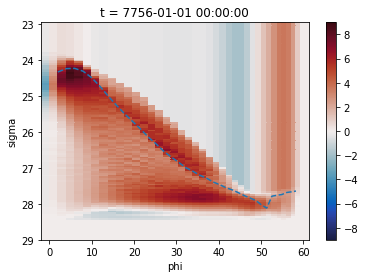

In [21]:
psi.coords['sigma'] = ds.grhow_0
psi.coords['phi'] = ds.gphif.isel({'x_f':0}).drop_vars('x_f')

psi[0].T.plot.pcolormesh(x='phi', y='sigma', cmap=cm.cm.balance, vmin=-9, vmax=9)
plt.plot(ds.gphit.isel({'x_c':0, 'y_c':slice(2,-2)}), sigma_mld.isel({'t':0, 'y_c':slice(2,-2), 'x_c':slice(2,-2)}).mean(dim='x_c'), '--')
plt.gca().invert_yaxis()

# Convert to depth coordinates for the plotting

We want to get the zonal mean depth for each density

## Other method to compute average depth of iso density

In [22]:
%%time
mean_depth_isopycnal = ds.grhow_0*np.NaN*ds.vos.isel({'x_c':0}).drop_vars('x_c')

ds_density = ds['sigma_V']

for (i,sigma) in enumerate(ds.grhow_0):
    upper_t_point_index = xr.where((ds_density <= sigma).sum(dim='z_c')>35, 35, (ds_density <= sigma).sum(dim='z_c'))
    upper_t_point_index = xr.where(sigma < ds_density.isel({'z_c':slice(None,-1)}).min(dim='z_c'), 0, upper_t_point_index)
    upper_t_point_index = xr.where(sigma > ds_density.isel({'z_c':slice(None,-1)}).max(dim='z_c'), 35, upper_t_point_index)
    
    lower_t_point_index = xr.where(35-(ds_density >= sigma).sum(dim='z_c')<0, 0, 35-(ds_density >= sigma).sum(dim='z_c'))
    lower_t_point_index = xr.where(sigma < ds_density.isel({'z_c':slice(None,-1)}).min(dim='z_c'), 0, lower_t_point_index)
    lower_t_point_index = xr.where(sigma > ds_density.isel({'z_c':slice(None,-1)}).max(dim='z_c'), 35, lower_t_point_index)
    
    depth_up = grid.interp(ds.gdept_0, axis='Y', boundary='extend').isel({'z_c':upper_t_point_index})
    depth_down = grid.interp(ds.gdept_0, axis='Y', boundary='extend').isel({'z_c':lower_t_point_index})
    mean_depth_isopycnal[i] = grid.average((depth_up + depth_down)/2, axis='X')
    #mean_depth_isopycnal[i] = ((depth_up + depth_down)/2).isel({'t':0, 'x_c':slice(1,-1)}).mean(dim='x_c')

CPU times: user 1.66 s, sys: 3.51 ms, total: 1.67 s
Wall time: 1.66 s


In [23]:
mean_depth_isopycnal[{'s_f':20,'t':0}]

<xarray.DataArray (y_f: 40)>
array([  10.83635048,   10.83635048,   13.33621848,   15.28073015,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        ,    5.        ,    5.        ,
          5.        ,    5.        , 2002.8881987 , 1374.4670966 ])
Coordinates:
    s_f      float64 19.5
    t        object 7756-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5

Text(0.5, 0, 'latitude')

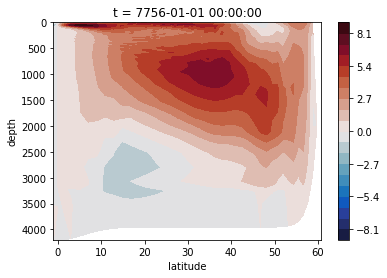

In [24]:
psi.coords['depth'] = mean_depth_isopycnal
psi.coords['phi'] = ds.gphif.isel({'x_f':0}).drop_vars('x_f')

psi[{'t':0}].plot.contourf(
    x='phi',
    y='depth',
    cmap=cm.cm.balance,
    levels=np.linspace(-9,9,21)
)

plt.gca().invert_yaxis()
plt.ylim(4200,0)

plt.ylabel('depth')
plt.xlabel('latitude')

Text(0.5, 0, 'latitude')

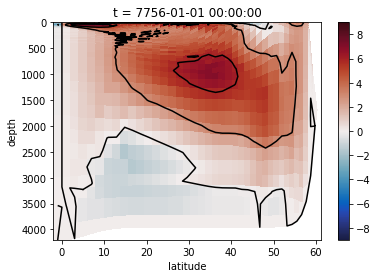

In [25]:
psi[{'t':0}].plot.pcolormesh(
    x='phi',
    y='depth',
    cmap=cm.cm.balance,
    vmin=-9,
    vmax=9
)

psi[{'t':0}].plot.contour(
    x='phi',
    y='depth',
    colors='k',
    levels=np.linspace(-9,9,7)
)

plt.gca().invert_yaxis()
plt.ylim(4200,0)

plt.ylabel('depth')
plt.xlabel('latitude')

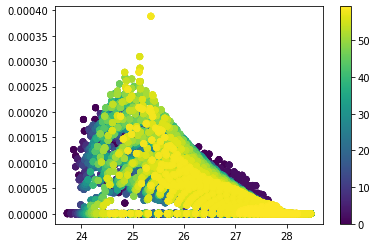

In [26]:
selection = {'x_c':slice(1,-1), 'y_c':slice(1,-1), 'z_c':slice(0,-1)}
plt.scatter(ds.sigma[selection].T, ds.bn2[selection].T, marker='o', c=(ds.gphit + ds.sigma*0)[selection])
plt.colorbar()

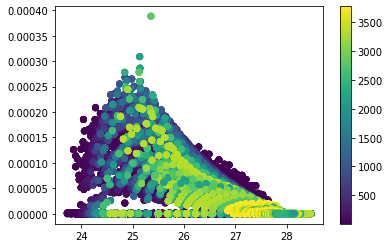

In [27]:
selection = {'x_c':slice(1,-1), 'y_c':slice(1,-1), 'z_c':slice(0,-1)}
plt.scatter(ds.sigma[selection].T, ds.bn2[selection].T, marker='o', c=(ds.gdept_0 + ds.sigma*0)[selection])
plt.colorbar()

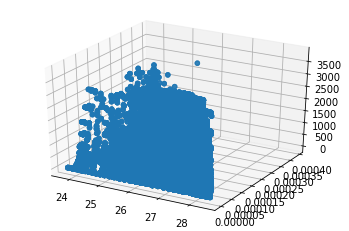

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds.sigma[selection].T, ds.bn2[selection].T, (ds.gdept_0 + ds.sigma*0)[selection])

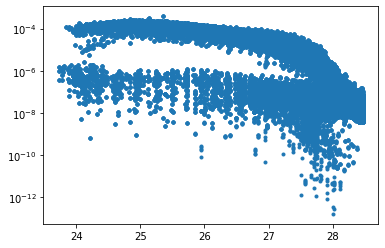

In [29]:
plt.semilogy(ds.sigma[selection].data.flatten(), ds.bn2[selection].data.flatten(), '.')

In [30]:
(0*ds.sigma + ds.gphit)[selection].data.flatten().shape

(126350,)

In [35]:
ds.sigma.coords['z_c'].shape[0]

36

In [36]:
mean_depth_isopycnal

<xarray.DataArray (s_f: 121, t: 5, y_f: 40)>
array([[[   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ]],

       [[   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ]],

       [[   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2002.8881987 , 1374.4670966 ]],

       ...,

       [[4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ]],

       [[4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ]],

       [[4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ],
        [4204.36678604, 4204.36678604, 4176.24176609, ...,
         2960.7882637 , 2002.8881987 , 1374.4670966 ]]])
Coordinates:
  * s_f      (s_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 116.5 117.5 118.5 119.5
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5

('t', 'y_f', 's_f')

In [44]:
grid.average(ds.sigma_V, axis='X').min(dim='z_c') * ds.grhow_0

<xarray.DataArray (t: 5, y_f: 40, s_f: 121)>
array([[[557.54684989, 558.76022715, 559.9736044 , ..., 700.72536629,
         701.93874355, 703.1521208 ],
        [557.54684989, 558.76022715, 559.9736044 , ..., 700.72536629,
         701.93874355, 703.1521208 ],
        [554.94580703, 556.15352369, 557.36124036, ..., 697.45637336,
         698.66409002, 699.87180669],
        ...,
        [633.46073878, 634.8393258 , 636.21791283, ..., 796.13400793,
         797.51259496, 798.89118198],
        [321.84869909, 322.54913151, 323.24956394, ..., 404.49972519,
         405.20015761, 405.90059004],
        [ 10.39758291,  10.42021095,  10.44283899, ...,  13.06769125,
          13.09031929,  13.11294733]],

       [[557.54672494, 558.76010192, 559.97347891, ..., 700.72520925,
         701.93858624, 703.15196322],
        [557.54672494, 558.76010192, 559.97347891, ..., 700.72520925,
         701.93858624, 703.15196322],
        [554.94570426, 556.1534207 , 557.36113714, ..., 697.4562442 ,
         698.66396064, 699.87167708],
        ...,
        [633.4606558 , 634.83924264, 636.21782949, ..., 796.13390364,
         797.51249049, 798.89107733],
        [321.84863619, 322.54906848, 323.24950077, ..., 404.49964614,
         405.20007842, 405.90051071],
        [ 10.39758291,  10.42021095,  10.44283899, ...,  13.06769125,
          13.09031929,  13.11294733]],

       [[557.5465375 , 558.75991408, 559.97329066, ..., 700.72497369,
         701.93835026, 703.15172684],
        [557.5465375 , 558.75991408, 559.97329066, ..., 700.72497369,
         701.93835026, 703.15172684],
        [554.9455335 , 556.15324956, 557.36096563, ..., 697.45602958,
         698.66374565, 699.87146172],
        ...,
        [633.4606544 , 634.83924125, 636.21782809, ..., 796.13390189,
         797.51248873, 798.89107558],
        [321.84866996, 322.54910232, 323.24953468, ..., 404.49968858,
         405.20012094, 405.9005533 ],
        [ 10.39758291,  10.42021095,  10.44283899, ...,  13.06769125,
          13.09031929,  13.11294733]],

       [[557.54666979, 558.76004666, 559.97342352, ..., 700.72513994,
         701.93851681, 703.15189367],
        [557.54666979, 558.76004666, 559.97342352, ..., 700.72513994,
         701.93851681, 703.15189367],
        [554.94568127, 556.15339766, 557.36111405, ..., 697.45621531,
         698.6639317 , 699.87164809],
        ...,
        [633.46077851, 634.83936562, 636.21795273, ..., 796.13405786,
         797.51264497, 798.89123209],
        [321.84869493, 322.54912735, 323.24955977, ..., 404.49971997,
         405.20015238, 405.9005848 ],
        [ 10.39758291,  10.42021095,  10.44283899, ...,  13.06769125,
          13.09031929,  13.11294733]],

       [[557.54682151, 558.76019871, 559.9735759 , ..., 700.72533063,
         701.93870782, 703.15208502],
        [557.54682151, 558.76019871, 559.9735759 , ..., 700.72533063,
         701.93870782, 703.15208502],
        [554.94581265, 556.15352933, 557.361246  , ..., 697.45638042,
         698.6640971 , 699.87181378],
        ...,
        [633.46076937, 634.83935647, 636.21794356, ..., 796.13404638,
         797.51263348, 798.89122057],
        [321.84868443, 322.54911683, 323.24954922, ..., 404.49970677,
         405.20013916, 405.90057156],
        [ 10.39758291,  10.42021095,  10.44283899, ...,  13.06769125,
          13.09031929,  13.11294733]]])
Coordinates:
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5
  * s_f      (s_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 116.5 117.5 118.5 119.5